In [1]:

import matplotlib.pyplot as plt
from shapely.geometry import LineString
from planners.lazy_prm import LazyPRM
from utils.lazy_prm_visualize import lazy_prm_visualize
from utils.collision_checker import CollisionChecker

In [2]:
scene = {
    "wall": LineString([(6, 18), (6, 8), (16, 8), (16, 18)]).buffer(1.0)
}

limits = ((0, 22), (0, 22))  # Sampling-Bereich


In [3]:
# CollisionChecker erstellen
collision_checker = CollisionChecker(scene, limits)

# LazyPRM mit dem CollisionChecker initialisieren
planner = LazyPRM(collision_checker, limits)



In [4]:
start = [[2, 20]]
goal = [[20, 2]]

config = {
    "initialRoadmapSize": 150,
    "updateRoadmapSize": 50,
    "kNearest": 10,
    "maxIterations": 25
}


In [5]:
path = planner.plan_path(start, goal, config)
print("Pfad gefunden!" if path else "Kein Pfad gefunden.")
print("Pfadknoten:", path)


Pfad gefunden!
Pfadknoten: ['start', 44, 115, 82, 73, 108, 144, 16, 81, 119, 'goal']


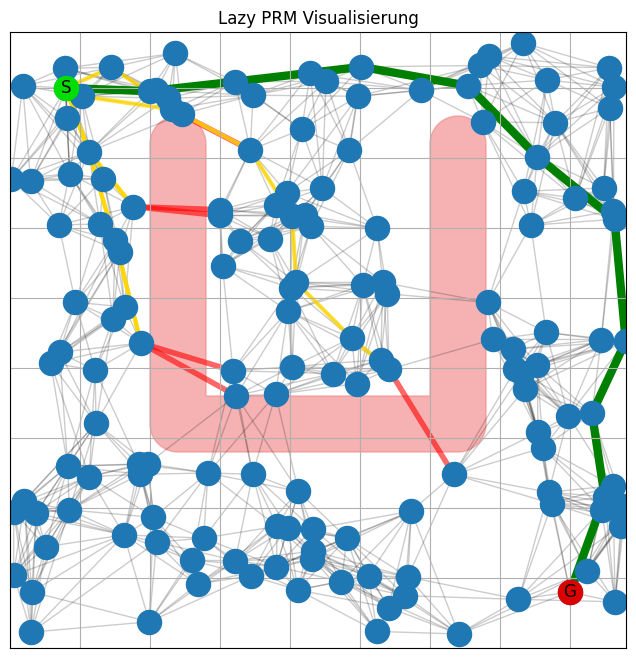

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
lazy_prm_visualize(planner, solution=path, ax=ax)
plt.show()

In [7]:
from scipy.spatial.distance import euclidean

if path:
    coords = planner.get_path_coordinates(path)
    length = sum(euclidean(a, b) for a, b in zip(coords[:-1], coords[1:]))
    print(f"Pfadlänge: {length:.2f}")
else:
    print("Keine Pfadlänge berechenbar.")


Pfadlänge: 35.41
